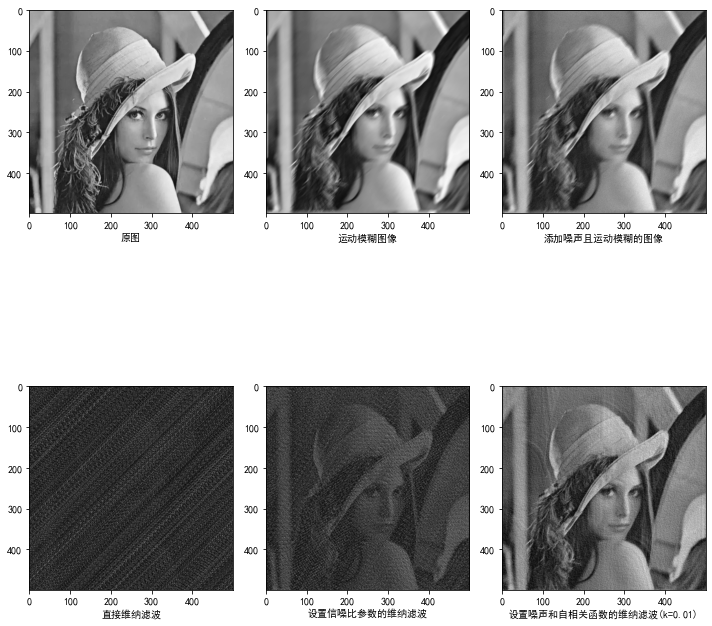

In [41]:
'''
采用维纳滤波要求：未退化的图像和噪声已知
'''
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
import math
import cv2
  
# 仿真运动模糊：input 图像大小和运动角度 output：运动模糊模型
def motion_process(image_size,motion_angle):
    PSF = np.zeros(image_size)
#  print(image_size)  # (500, 500)
    center_position=(image_size[0]-1)/2
#  print(center_position)  #  249.5
    slope_tan=math.tan(motion_angle*math.pi/180)
    slope_cot=1/slope_tan
    if(slope_tan<=1):
        for i in range(15):
            offset=round(i*slope_tan) #((center_position-i)*slope_tan)
            PSF[int(center_position+offset),int(center_position-offset)]=1
    if(slope_tan>1):
        for i in range(15):
            offset=round(i*slope_cot)
            PSF[int(center_position-offset),int(center_position+offset)]=1
    return PSF / PSF.sum()
  
#对图片进行运动模糊 input 原图像、运动模糊模型、运动模型、eps ；output 运动模糊图像
def make_blurred(input, PSF, eps):
    input_fft = fft.fft2(input)# 进行二维数组的傅里叶变换
    PSF_fft = fft.fft2(PSF)+ eps
    blurred = fft.ifft2(input_fft * PSF_fft)
    blurred = np.abs(fft.fftshift(blurred))
    return blurred

# 维纳滤波 input 加噪图像 运动模糊图像 eps，K  output 还原图像
def wiener(input,PSF,eps,K):  #维纳滤波，K=0.01
    input_fft=fft.fft2(input)
    PSF_fft=fft.fft2(PSF) +eps
    PSF_fft_1=np.conj(PSF_fft) /(np.abs(PSF_fft)**2 + K)
    result=fft.ifft2(input_fft * PSF_fft_1)
    result=np.abs(fft.fftshift(result))
    return result
  
image = cv2.imread('./lena.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
img_h=image.shape[0]
img_w=image.shape[1]

# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 12))
plt.subplot(231)
plt.xlabel("原图")
plt.gray()
plt.imshow(image)  #显示原图像

plt.gray()
#进行运动模糊处理
PSF = motion_process((img_h,img_w), 60)  # 运动模糊模型
blurred = np.abs(make_blurred(image, PSF, 1e-3))  
plt.subplot(232)
plt.xlabel("运动模糊图像")
plt.imshow(blurred)

blurred_noisy=blurred + 0.1 * blurred.std() *np.random.standard_normal(blurred.shape) #添加噪声,standard_normal产生随机的函数 
plt.subplot(233)
plt.xlabel("添加噪声且运动模糊的图像")
plt.imshow(blurred_noisy)  #显示添加噪声且运动模糊的图像

result1=wiener(blurred_noisy,PSF,0,K=0)   #直接维纳滤波
plt.subplot(234)
plt.xlabel("直接维纳滤波")
plt.imshow(result1)
result2=wiener(blurred_noisy,PSF,0.1+1e-3,K=0)   #设置信噪比参数的维纳滤波
plt.subplot(235)
plt.xlabel("设置信噪比参数的维纳滤波")
plt.imshow(result2)

result3=wiener(blurred_noisy,PSF,0.1+1e-3,K=0.01)   #设置噪声和自相关函数的维纳滤波
plt.subplot(236)
plt.xlabel("设置噪声和自相关函数的维纳滤波(k=0.01)")
plt.imshow(result3)
plt.tight_layout()